# Multi-modality and Mental Imagery

**Multi-modality (WHISPER)**

In this workshop you will recreate (partial) results from the paper ["Deep speech-to-text models capture the neural basis of spontaneous speech in
everyday conversations](https://www.biorxiv.org/content/10.1101/2023.06.26.546557v1.full.pdf)".

You will need to:
1. Use WhisperX to align audio and transcript in time
2. Extract speech and language embeddings from Whisper model
3. Perform dimension reduction anaylsis (PCA/TSNE) to 2D on both types of  embeddings
4. Cluster them according to phonetic categories (Phonemes) and lexical
categories (Part Of Speech).
5. Train a classifier on the embeddings for the phonetic and lexical categories.

As audio you will be using the first 10 min of the podcast "[So a Monkey and a Horse Walk Into a Bar](https://www.thisamericanlife.org/631/so-a-monkey-and-a-horse-walk-into-a-bar)" (the transcript for which is availible so you can evaluate the model's performance on it if you want).

Install **whisperx** from [github repo](https://github.com/m-bain/whisperX).

You will use it to get the time-stamps for each word, which then will serve as inputs to the original Whisper model.

In [1]:
!pip install git+https://github.com/m-bain/whisperx.git
!pip install -U openai-whisper

  Cloning https://github.com/m-bain/whisperx.git to /tmp/pip-req-build-5_gu2_rb
  Running command git clone --filter=blob:none --quiet https://github.com/m-bain/whisperx.git /tmp/pip-req-build-5_gu2_rb
  Resolved https://github.com/m-bain/whisperx.git to commit 8227807fa9e076901ea4b4fbbf79c9777a6f5e03
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/SYSTRAN/faster-whisper.git (to revision 0.10.0) to /tmp/pip-install-j8dga16v/faster-whisper_4e7ab913f9b544b6a8133dea463fea61
  Running command git clone --filter=blob:none --quiet https://github.com/SYSTRAN/faster-whisper.git /tmp/pip-install-j8dga16v/faster-whisper_4e7ab913f9b544b6a8133dea463fea61
  Running command git checkout -q e1a218fab1ab02d637b79565995bf1a9c4c83a09
  Resolved https://github.com/SYSTRAN/faster-whisper.git to commit e1a218fab1ab02d637b79565995bf1a9c4c83a09
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 208.7/208.7 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 798.6/798.6 kB 8.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 15.9 MB/s eta 0:00:00
  Created wheel for openai-whisper: filename=openai_whisper-20231117-py3-none-any.whl size=801356 sha256=de60ff67c8fe02117e1c8b3aeff3cbe1497c6ea4a893d089b455c9b4ae7c3fe0
  Stored in directory: /root/.cache/pip/wheels/d0/85/e1/9361b4cbea7dd4b7f6702fa4c3afc94877952eeb2b62f45f56
Successfully built openai-whisper
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
llmx 0.0.15a0 requires cohere, which is not installed.
llmx 0.0.15a0 requires openai, which is not installed.


Load the WhisperX model and the audio of the podcast, transcribe it into text using the model and then align it.

Take a look at the exmaple in the README of the WhisperX [repo](https://github.com/m-bain/whisperX) to see how it's done.

In [2]:
import whisperx
import gc
import torch

device = "cuda"
audio_file = "MITM_podcast_10min.mp3"
batch_size = 16 # reduce if low on GPU mem
compute_type = "float16" # change to "int8" if low on GPU mem (may reduce accuracy)

# 1. Transcribe with original whisper (batched)
model = whisperx.load_model("large-v2", device, compute_type=compute_type)

audio = whisperx.load_audio(audio_file)
result = model.transcribe(audio, batch_size=batch_size)

# delete model if low on GPU resources
gc.collect(); torch.cuda.empty_cache(); del model

# 2. Align whisper output
model_a, metadata = whisperx.load_align_model(language_code=result["language"], device=device)
result = whisperx.align(result["segments"], model_a, metadata, audio, device, return_char_alignments=False)

gc.collect(); torch.cuda.empty_cache(); del model_a


/usr/local/lib/python3.10/dist-packages/pyannote/audio/core/io.py:43: UserWarning: torchaudio._backend.set_audio_backend has been deprecated. With dispatcher enabled, this function is no-op. You can remove the function call.
  torchaudio.set_audio_backend("soundfile")
/usr/local/lib/python3.10/dist-packages/torch_audiomentations/utils/io.py:27: UserWarning: torchaudio._backend.set_audio_backend has been deprecated. With dispatcher enabled, this function is no-op. You can remove the function call.
  torchaudio.set_audio_backend("soundfile")


config.json:   0%|          | 0.00/2.80k [00:00<?, ?B/s]

vocabulary.txt:   0%|          | 0.00/460k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.20M [00:00<?, ?B/s]

model.bin:   0%|          | 0.00/3.09G [00:00<?, ?B/s]

No language specified, language will be first be detected for each audio file (increases inference time).


100%|█████████████████████████████████████| 16.9M/16.9M [00:01<00:00, 11.0MiB/s]
INFO:pytorch_lightning.utilities.migration.utils:Lightning automatically upgraded your loaded checkpoint from v1.5.4 to v2.1.3. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../root/.cache/torch/whisperx-vad-segmentation.bin`


Model was trained with pyannote.audio 0.0.1, yours is 3.1.1. Bad things might happen unless you revert pyannote.audio to 0.x.
Model was trained with torch 1.10.0+cu102, yours is 2.1.0+cu121. Bad things might happen unless you revert torch to 1.x.
Detected language: en (1.00) in first 30s of audio...


Downloading: "https://download.pytorch.org/torchaudio/models/wav2vec2_fairseq_base_ls960_asr_ls960.pth" to /root/.cache/torch/hub/checkpoints/wav2vec2_fairseq_base_ls960_asr_ls960.pth
100%|██████████| 360M/360M [00:02<00:00, 150MB/s]


Using the resulting timestamps create a DF which contains two columns "token", "audio_onset", "audio_offset" with the corresponding values for each token in the transcript.


Note: WhisperX doesn't return timestamps for some words, so make sure to filter those out.

In [18]:
import numpy as np
import pandas as pd

tokens_arr, audio_onset_arr, audio_offset_arr = [], [], []
for segment in result["segments"]:
  tokens_arr += [word_dict['word'] for word_dict in segment['words'] if 'start' in word_dict]
  audio_onset_arr += [word_dict['start'] for word_dict in segment['words'] if 'start' in word_dict]
  audio_offset_arr += [word_dict['end'] for word_dict in segment['words'] if 'start' in word_dict]

words_arr = [word.lower().strip() for word in tokens_arr]
podcast_df = pd.DataFrame({"token": tokens_arr, "audio_onset": audio_onset_arr, "audio_offset": audio_offset_arr,
                           "word" : words_arr})


Extract speech and language embeddings from Whisper model for the podcast audio.

In [4]:
import whisper
import random
import torch.utils.data as data

device =  torch.device("cuda")

class AudioDataset(data.Dataset):
    def __init__(self, model_type, tokenizer,  processor, audio,
                 conversation_df, transform=None):
        self.model_type = model_type
        self.tokenizer = tokenizer
        self.processor = processor
        self.conversation_df = conversation_df
        self.audio = audio
        self.transform = transform

    def __len__(self):
        return len(self.conversation_df.index)

    def __getitem__(self, idx):
        sampling_rate = 16000

        ####################
        ## for decoder model ##
        ####################
        if self.model_type == "de-only":
            # get word onset and offset
            chunk_offset = self.conversation_df["audio_offset"].iloc[idx]
            chunk_onset = np.max([0, (chunk_offset - 30)])
            start_windows = 0

        ######################
        ## for encoder only ##
        ######################
        elif self.model_type == "en-only":
            # get current word onset
            word_onset = self.conversation_df.audio_onset.iloc[idx]
            chunk_offset = word_onset + 0.2725
            num_windows = 12
            chunk_onset = np.max([0, (chunk_offset - 30)])

            # function that gives start of windows
            if chunk_offset < 30:
                start_windows = int((((self.conversation_df["audio_onset"][idx] - chunk_onset) * 1000)- 7.5)// 20 + 3)
            else:
                start_windows = 1500 - num_windows

        chunk_data = self.audio[int(chunk_onset * sampling_rate) : int(chunk_offset * sampling_rate)]

        # generate input features
        inputs = self.processor.feature_extractor(chunk_data, return_tensors="pt", sampling_rate=sampling_rate)
        input_features = inputs.input_features

        if idx == 0:
            context_tokens = self.conversation_df.iloc[:8]["token"].tolist()
            context_tokens.extend(
                self.conversation_df[
                    (self.conversation_df.audio_onset >= chunk_onset)
                    & (self.conversation_df.audio_offset <= chunk_offset)]["token"].tolist())
        else:

            # get all tokens within input window
            context_df = self.conversation_df[(self.conversation_df["audio_onset"] >= chunk_onset)
                & ( self.conversation_df["audio_onset"]
                    <= self.conversation_df.iloc[idx].audio_onset ) ]

            # sort on word onset
            context_df = context_df.sort_values("audio_onset")
            if len(context_df.index) == 0:
                context_df = context_df.append(self.conversation_df.iloc[idx])
            context_tokens = context_df["token"].tolist()

        # add prefix tokens (for large v2):
        prefix_tokens = self.tokenizer.tokenize( "<|startoftranscript|> <|en|> <|transcribe|>")
        prefix_tokens = self.tokenizer.tokenize("<|startoftranscript|>")
        prefix_tokens2 = self.tokenizer.tokenize( "<|startoftranscript|><|notimestamps|>")
        prefix_tokens.extend(context_tokens)
        prefix_tokens2.extend(context_tokens)
        context_tokens = prefix_tokens
        context_tokens2 = prefix_tokens2

        context_token_ids = self.processor.tokenizer.encode(context_tokens, add_special_tokens=False, return_tensors="pt")
        context_token_ids2 = self.processor.tokenizer.encode(context_tokens2, add_special_tokens=False, return_tensors="pt")

        sample = {"input_features": input_features.squeeze(),
                  "context_token_ids": context_token_ids.squeeze(),
                  "context_token_ids2": context_token_ids2.squeeze(),
                  "start_windows": start_windows}

        return sample


def extract_select_vectors_concat(num_windows, start_windows, array):
    # concatenating all windows from start_windows to start_windows + num_windows
    x = array[:, start_windows, :]

    for i in range(1, num_windows):
        x = torch.cat((x, array[:, start_windows + i, :]), 1)

    return x

def extract_select_vectors_concat_all_layers(num_windows, start_windows, array, layers=None):
    array_actual = tuple(y.cpu() for y in array)
    all_layers_x = dict()
    for layer_idx in layers:
        array = array_actual[layer_idx]
        all_layers_x[layer_idx] = extract_select_vectors_concat(num_windows, start_windows, array)
    return all_layers_x


def extract_select_vectors(batch_idx, array):
    if batch_idx == 0:
        x = array[0, :-1, :].clone()
        if array.shape[0] > 1:
            rem_sentences_preds = array[1:, -1, :].clone()
            x = torch.cat([x, rem_sentences_preds], axis=0)
    else:
        try:
            x = array[:, -1, :].clone()
        except:
            x = array[:, -2, :].clone()
    return x


def extract_select_vectors_all_layers(batch_idx, array, layers=None):
    array_actual = tuple(y.cpu() for y in array)

    all_layers_x = dict()
    for layer_idx in layers:
        array = array_actual[layer_idx]
        all_layers_x[layer_idx] = extract_select_vectors(batch_idx, array)

    return all_layers_x


def make_dataloader_from_dataset(input_dataset):
    data_dl = data.DataLoader(input_dataset, batch_size=1, shuffle=False)
    return data_dl


def extract_embeddings(model, data_dl, embd_type, layer_idx):
  with torch.no_grad():
        model = model.to(device)
        model.eval()
        all_embeddings = []

        for batch_idx, batch in enumerate(data_dl):
            input_features = batch["input_features"].to(device)
            start_windows = batch["start_windows"].item()
            decoder_input_ids = batch["context_token_ids"].to(device)

            if embd_type == "speech":
              #encoder-only
              num_windows = 12
              model_output = model(input_features=input_features,
                                  decoder_input_ids=decoder_input_ids,
                                  output_hidden_states=True)
              embeddings = extract_select_vectors_concat_all_layers(num_windows,
                                                                    start_windows,
                                                                    model_output.encoder_hidden_states,
                                                                    layer_idx)

            elif embd_type == "language":
              #decoder only
              encoder_outputs = torch.zeros(1, 1500, 384).to(device)
              cross_attn_head_mask = torch.zeros(model.config.decoder_layers,
                                                 model.config.decoder_attention_heads).to(device)
              model_output = model(input_features=input_features,
                                  decoder_input_ids=decoder_input_ids,
                                  output_hidden_states=True,
                                  cross_attn_head_mask=cross_attn_head_mask,
                                  encoder_outputs=encoder_outputs)
              embeddings = extract_select_vectors_all_layers(batch_idx + 1, model_output.decoder_hidden_states, layer_idx)

            all_embeddings.append(embeddings)
  return all_embeddings

Load pre-trained "tiny" version of Whisper from HuggingFace.

In [5]:
from transformers import AutoProcessor, AutoConfig, AutoModelForSpeechSeq2Seq, AutoTokenizer
import whisper

model_name = "openai/whisper-tiny"

config = AutoConfig.from_pretrained(model_name)
num_layers = getattr(config, "n_layer",getattr(config,"num_layers",
                      getattr(config, "num_hidden_layers", None),),)
layer_idxs = [num_layers]

model = AutoModelForSpeechSeq2Seq.from_pretrained(model_name)
model.config.forced_decoder_ids = None
tokenizer = AutoTokenizer.from_pretrained(model_name, add_prefix_space=True)
processor = AutoProcessor.from_pretrained(model_name)

config.json:   0%|          | 0.00/1.98k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/151M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/3.72k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/805 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/836k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.48M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/494k [00:00<?, ?B/s]

normalizer.json:   0%|          | 0.00/52.7k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.08k [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


preprocessor_config.json:   0%|          | 0.00/185k [00:00<?, ?B/s]

Use Whisper to load the audio, and the code provided to you to create an AudioDataset and matching dataloader object from it.

Then extract the speech and language embedding.

Note: this section could take a ~6-10 minutes to run (depending on your machine).

In [6]:
audio = whisper.load_audio(audio_file)

speech_input_dataset = AudioDataset("en-only", tokenizer,  processor,
                                     audio, podcast_df)
speech_input_dl = make_dataloader_from_dataset(speech_input_dataset)
speech_embeddings = extract_embeddings(model, speech_input_dl, "speech", layer_idxs)

lang_input_dataset = AudioDataset("de-only", tokenizer,  processor,
                                   audio, podcast_df)
lang_input_dl = make_dataloader_from_dataset(lang_input_dataset)
lang_embeddings = extract_embeddings(model, lang_input_dl, "language", layer_idxs)

To cluster the embeddings by phonetic and lexical categories you first need to calculate the matching phoneme/POS for each token in the dataframe.

Note: since each word is made up of ultiple phonemes we will use the **first** phoneme of each word to represent it (since this matches the onset of the word).

For phoneme values use this dict: http://www.speech.cs.cmu.edu/cgi-bin/cmudict

For POS values use nltk library: https://www.nltk.org/book/ch05.html

Note: using nltk.download('all') is recommended

In [19]:
import nltk
# nltk.download('all')

def add_phoneme(df):
    cmu_dict_filename = "cmudict-0.7b"
    pdict = {}
    with open(cmu_dict_filename, "r", encoding="ISO-8859-1") as f:
        for line in f.readlines():
            if not line.startswith(";;;"):
                parts = line.rstrip().split()
                word = parts[0].lower()
                phones = [phone.rstrip("012") for phone in parts[1:]]
                pdict[word] = phones[0]

    words2_first_phoneme = df.apply(lambda x: pdict.get(x["word"].lower()), axis=1)
    df = df.assign(phoneme=words2_first_phoneme)
    has_matching_phoneme_mask = ~df.phoneme.isnull()
    df = df[has_matching_phoneme_mask].reset_index()
    indxs_with_matching_phoneme = np.where(has_matching_phoneme_mask)[0]
    return df, indxs_with_matching_phoneme


def add_pos_nltk(df):
    _, part_of_speech = zip(*nltk.pos_tag(df["word"], tagset="universal"))
    df = df.assign(POS=part_of_speech)
    return df


podcast_df, indxs_with_matching_phoneme = add_phoneme(podcast_df)
podcast_df = add_pos_nltk(podcast_df)


Filter out embeddings which have no matching phoneme label.

Then, calculate avergae speech and language embeddings for each unique word in the DataFrame over all apperances.

From now on use these embeddings for the visualizations.

In [26]:
speech_embeddings_arr = np.array([list(embd.values())[0].cpu().numpy() for embd in speech_embeddings]).squeeze()
speech_embeddings_arr = speech_embeddings_arr[indxs_with_matching_phoneme, :]

lang_embeddings_arr = np.array([list(embd.values())[0].cpu().numpy() for embd in lang_embeddings]).squeeze()
lang_embeddings_arr = lang_embeddings_arr[indxs_with_matching_phoneme, :]

unique_words = podcast_df["word"].unique()
num_unique_words = len(unique_words)

unique_word_indxs_list = [np.where(podcast_df["word"] == word)[0] for word in unique_words]
unique_word_POS = [podcast_df["POS"][unique_word_indxs_list[i][0]] for i in range(num_unique_words)]
unique_word_phoneme = [podcast_df["phoneme"][unique_word_indxs_list[i][0]] for i in range(num_unique_words)]

unique_word_avg_speech_embed_arr =  np.array([np.mean(speech_embeddings_arr[unique_word_indxs_list[i], :], axis=0) for i in range(num_unique_words)])
unique_word_avg_lang_embed_arr =  np.array([np.mean(lang_embeddings_arr[unique_word_indxs_list[i], :], axis=0) for i in range(num_unique_words)])

unique_words_df = pd.DataFrame({'word': unique_words, 'POS': unique_word_POS, 'phoneme': unique_word_phoneme})


Now you can use t-SNE to visualize the embeddings in 2D space and color them by POS and by Phoneme.

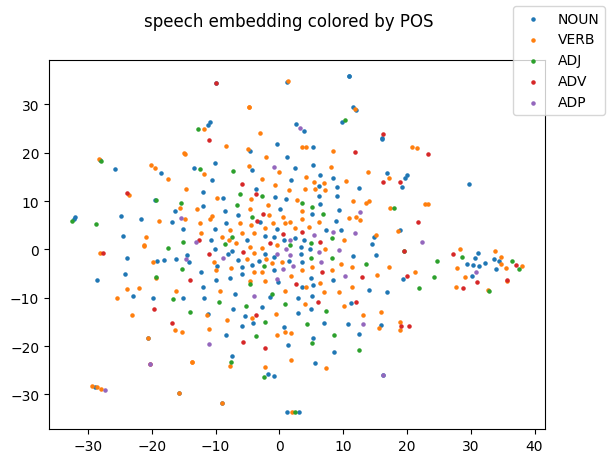

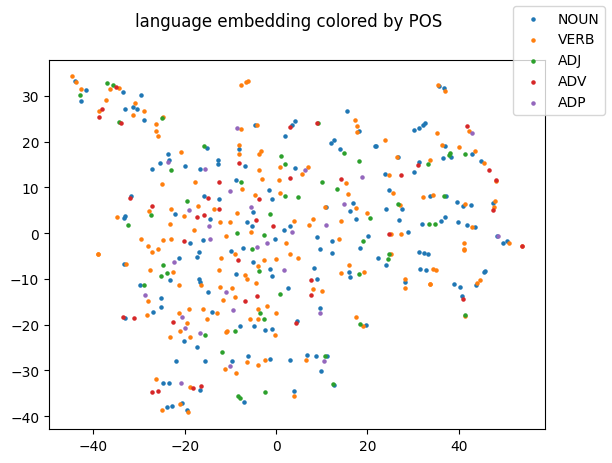

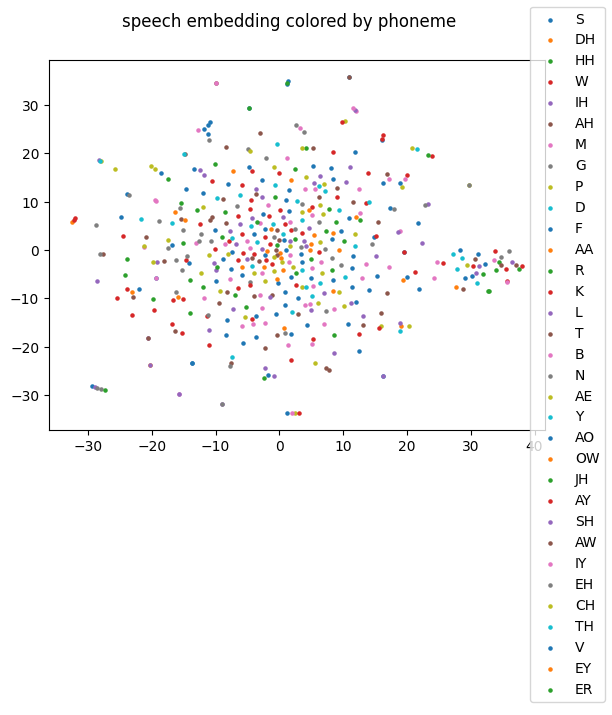

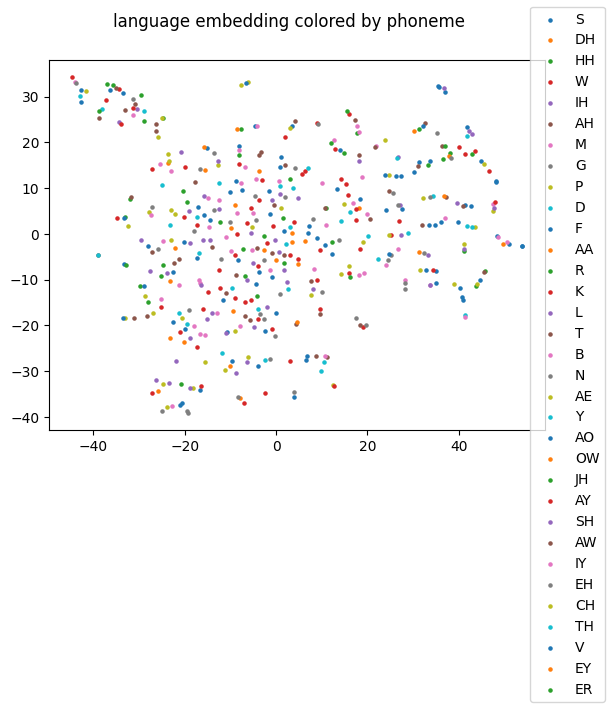

In [15]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


speech_embeddings_2d = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=10).fit_transform(unique_word_avg_speech_embed_arr)
lang_embeddings_2d = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=10).fit_transform(unique_word_avg_lang_embed_arr)

pos_names = ["NOUN", "VERB", "ADJ", "ADV", "ADP"]
phoneme_names = unique_words_df["phoneme"].unique()

category_name_to_labels_dict = {"POS": pos_names, "phoneme": phoneme_names}
embed_name_to_list_dict = {"speech": speech_embeddings_2d, "language": lang_embeddings_2d}

for category_name in category_name_to_labels_dict.keys():
  for embed_name in embed_name_to_list_dict.keys():
    fig, ax = plt.subplots()
    category_labels = category_name_to_labels_dict[category_name]
    embeddings_2d = embed_name_to_list_dict[embed_name]
    for label in category_labels:
      cond = unique_words_df[category_name] == label
      ax.scatter(embeddings_2d[cond, 0], embeddings_2d[cond, 1], label=label,
                  s=5)
    fig.legend()
    fig.suptitle(f"{embed_name} embedding colored by {category_name}")
    fig.savefig(f"{embed_name}_embd_{category_name}_cluster.png")


For each category (phonetic - Phoneme, lexical - POS):
- Train 2 simple linear classifers using either the language or speech embeddings as features and the category as labels.
- Compare the relevant classifiers' accuracy to each other and to to random choice.

Remember to split the samples into train and test sets, and calculate the accuracy on the test set.

You may find sklearn library useful

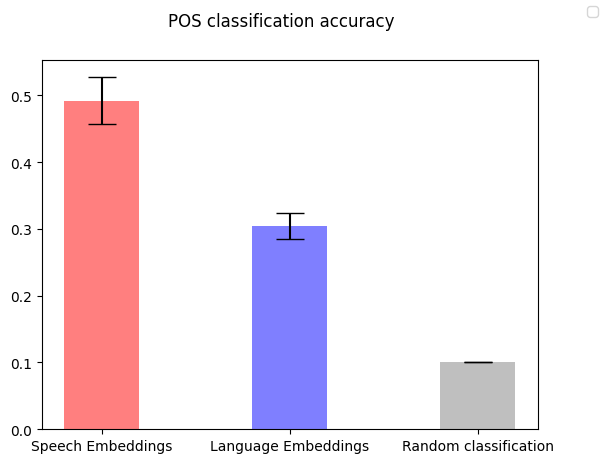

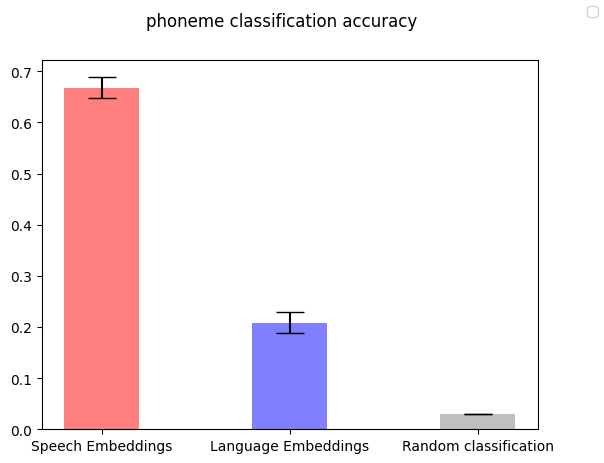

In [29]:
import numpy as np
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score

num_samples = len(unique_word_avg_speech_embed_arr)
num_train_samples = int(0.9*num_samples)
shuffled_indxs = np.random.permutation(range(num_samples))
train_indxs, test_indxs = shuffled_indxs[:num_train_samples], shuffled_indxs[num_train_samples:]

num_classifiers = 5

for category_name in category_name_to_labels_dict.keys(): #POS, phoneme
  embd_acc_list = [[], []]
  for i in range(num_classifiers):
    for j, features in enumerate([unique_word_avg_speech_embed_arr, unique_word_avg_lang_embed_arr]):
      X_train = features[train_indxs, :]
      Y_train = unique_words_df[category_name][train_indxs]

      clf = make_pipeline(StandardScaler(),
                          SGDClassifier(max_iter=100, tol=1e-3))
      clf.fit(X_train, Y_train)

      X_test = features[test_indxs, :]
      Y_test = unique_words_df[category_name][test_indxs]
      y_pred = clf.predict(X_test)
      embd_acc_list[j].append(accuracy_score(Y_test, y_pred))

  mean_embd_acc = [np.mean(embd_acc_list[0]), np.mean(embd_acc_list[1])]
  std_embd_acc = [np.std(embd_acc_list[0]), np.std(embd_acc_list[1])]

  fig, ax = plt.subplots()
  random_acc = 1.0/len(set(unique_words_df[category_name]))
  mean_embd_acc.append(random_acc)
  std_embd_acc.append(0)

  tick_label_list = ["Speech Embeddings", "Language Embeddings", "Random classification"]
  ax.bar([1, 1.5, 2], width=0.2, height=mean_embd_acc, tick_label=tick_label_list,
         color=['red', 'blue','grey'], yerr=std_embd_acc, align='center', alpha=0.5, ecolor='black', capsize=10)

  fig.legend()
  fig.suptitle(f"{category_name} classification accuracy")
  fig.savefig(f"{category_name}_linear_class.png")

**Mental Imagery**

Compare performance of unimodal (trained on text only) and multi-modal models on (visual) mental imagery tasks.
You can choose which models to experiment with and how to evalute their success in this type of task.

You can you use examples from [Pinker and Farah's paper](https://onlinelibrary.wiley.com/doi/pdfdirect/10.1207/s15516709cog1301_2) and/or come up with your own 🙂

First, set up the environment

In [10]:
!pip install transformers
!pip install torchmetrics
!pip install evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.5 MB/s eta 0:00:00


First try a unimodal model like BERT (using maksed prompts) or GPT (using open ended questions/prompts).

Note: when comparing BERT's token predictions to the correct answer, make sure to consider spaces and casing (lower/upper case).

In [8]:
PINKER_and_FARAH_pormpts = ["Imagine the number 7. Make the diagonal line vertical. Move the horizontal line down to the middle of the vertical line. Now rotate the figure 90 degrees to the left. This looks like the letter [MASK].",
                            "Imagine a capital letter B. Rotate it 90 degrees to the left. Put a triangle directly below it having the same width and pointing down. Remove the horizontal line. This looks like a [MASK].",
                            "Imagine a plus. Add a vertical line on the left side. Rotate the figure 90 degrees to the right. Now remove all lines to the left of the vertical line. This looks like the letter [MASK].",
                            "Imagine a capital letter D. Rotate it 90 degrees to the right. Put the number 4 above it. Now remove the horizontal segment of the 4 to the right of the vertical line. This looks like a [MASK].",
                            "Imagine a capital letter Q. Put the letter O next to it on the left. Remove the diagonal line. Now rotate the figure 90 degrees to the left. This looks like the number [MASK].",
                            "Imagine a capital letter K. Place a square next to it on the left side. Put a circle inside of the square. Now rotate the figure 90 degrees to the left. This looks like a [MASK].",
                            "Imagine a capital letter D. Rotate it 90 degrees to the left. Now place a capital J at the bottom. This looks like an [MASK].",
                            "Imagine a capital letter N. Connect a diagonal line from the top right corner to the bottom left corner. Now rotate the figure 90 degrees to the right. This looks like an [MASK].",
                            "Imagine a lowercase letter k. Surround the letter with a circle. Now remove the lower half of the letter, below where the lines intresect. This looks like a [MASK]."]

possible_answers =  [['T', 'E', 'Q', 'S', 'C'],
                    ['heart', 'cross',  'circle', 'triangle', 'square'],
                    ['F', 'A', 'X', 'O', 'B'],
                    ['boat', 'triangle', 'car', 'trapezoid', 'table'],
                    ['eight', '6', '10', 'three', '2'],
                    ['TV', 'house', 'square', 'triangle', 'boat'],
                    ['umbrella', 'apple', 'arrow', 'animal', 'hourglass'],
                    ['hourglass', 'oval', 'apple', 'egg', 'asterisk'],
                    ['clock', 'cross', 'square', 'boat', 'triangle']]


corr_answer_indxs = [0, 0, 0, 0, 0, 0, 0, 0, 0]


In [12]:
from transformers import pipeline


def probe_BERT(masked_prompts, possible_answers, corr_answer_ind):
  unmasker = pipeline('fill-mask', model='bert-large-cased', top_k=5000)
  num_possible_answers = len(possible_answers[0])
  model_probing_score = 0
  for i, prompt in enumerate(masked_prompts):
    bert_answers = unmasker(prompt)
    max_score = 0
    max_score_ind = -1
    for _, answer in enumerate(bert_answers):
      for j in range(num_possible_answers):
        if answer['token_str'].strip().lower() == possible_answers[i][j].lower():
          if max_score < answer['score']:
            max_score_ind = j
            max_score = answer['score']
    if max_score_ind == corr_answer_ind[i]:
      model_probing_score += 1
  return model_probing_score


bert_probing_score = probe_BERT(PINKER_and_FARAH_pormpts, possible_answers, corr_answer_indxs)
print(f"BERT was correct {bert_probing_score} out of {len(PINKER_and_FARAH_pormpts)} times")

Some weights of the model checkpoint at bert-large-cased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BERT was correct 0 out of 9 times


If you want to evaluate models like CLIP or FLAVA, you can use a common technique called [stroop-probing](https://github.com/TAU-VAILab/isbertblind/blob/main/probing/stroop_probe.py).
You can read about this method in the seminal paper "[Is BERT blind?](https://arxiv.org/abs/2303.12513)" and may find their repo helpful in general.

Stroop probing FLAVA

In [10]:
import numpy as np
import torch
from transformers import FlavaProcessor, FlavaModel
from transformers import set_seed
set_seed(42)


def probe_FLAVA(prompts, possible_answers, corr_answer_ind):
  tokenizer = FlavaProcessor.from_pretrained("facebook/flava-full")
  model = FlavaModel.from_pretrained("facebook/flava-full")
  num_possible_answers = len(possible_answers[0])

  def get_norm_embds(model, tokenizer, prompts):
    inputs = tokenizer(text=prompts, padding=True, return_tensors="pt")
    with torch.no_grad():
      v = model.get_text_features(**inputs)
      v = v[:, 0, :]
      v /= v.norm(p=2, dim=-1, keepdim=True)
      v = v.cpu().numpy()
    return v

  model_probing_score = 0
  for i in range(len(prompts)):
    cur_prompt = prompts[i]
    cur_prompt_vers = [cur_prompt] + [cur_prompt.replace('[MASK]', possible_answers[i][j]) for j in range(num_possible_answers)]
    text_embeds = get_norm_embds(model, tokenizer, cur_prompt_vers)
    base = text_embeds[0]
    modified = text_embeds[1:]
    scores = modified @ base
    max_sim_ind = np.argmax(scores)
    if max_sim_ind == corr_answer_ind[i]:
      model_probing_score += 1
  return model_probing_score


flava_probing_score = probe_FLAVA(PINKER_and_FARAH_pormpts, possible_answers, corr_answer_indxs)
print(f"FLAVA was correct {flava_probing_score} out of {len(PINKER_and_FARAH_pormpts)} times")



`text_config_dict` is provided which will be used to initialize `FlavaTextConfig`. The value `text_config["id2label"]` will be overriden.
`multimodal_config_dict` is provided which will be used to initialize `FlavaMultimodalConfig`. The value `multimodal_config["id2label"]` will be overriden.
`image_codebook_config_dict` is provided which will be used to initialize `FlavaImageCodebookConfig`. The value `image_codebook_config["id2label"]` will be overriden.


FLAVA was correct 4 out of 9 times
